<a href="https://colab.research.google.com/github/SabrinaBucelli/Model-Order-Project/blob/main/ModelOrderProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content
!git clone https://github.com/fvicini/CppToPython.git
%cd CppToPython/
!git submodule init
!git submodule update
!mkdir externals
%cd externals/
!cmake -DINSTALL_VTK=OFF -DINSTALL_LAPACK=OFF ../gedim/3rd_party_libraries
!make -j4
%cd ..
!mkdir release
%cd release
!cmake -DCMAKE_PREFIX_PATH="/content/CppToPython/externals/Main_Install/eigen3;/content/CppToPython/externals/Main_Install/triangle;/content/CppToPython/externals/Main_Install/tetgen;/content/CppToPython/externals/Main_Install/googletest;/content/CppToPython/externals/Main_Install/lapack" -DENABLE_TRIANGLE=ON -DENABLE_TETGEN=ON ../
!make -j4 GeDiM4Py
%cd /content/

/content
fatal: destination path 'CppToPython' already exists and is not an empty directory.
/content/CppToPython
mkdir: cannot create directory ‘externals’: File exists
/content/CppToPython/externals
-- Install Eigen3 release 3.4.0
-- Install GoogleTest release 1.11.0
-- Install triangle release 1.0.4
-- Install tetgen release 1.0.0
-- Configuring done (0.3s)
-- Generating done (0.0s)
-- Build files have been written to: /content/CppToPython/externals
[  3%] Performing update step for 'Eigen'
[  6%] Performing update step for 'googletest'
[  9%] Performing update step for 'tetgen'
[ 12%] Performing update step for 'triangle'
-- Already at requested ref: e2239ee6043f73722e7aa812a459f54a28552929
[ 15%] No patch step for 'googletest'
-- Already at requested ref: 3147391d946bb4b6c68edd901f2add6ac1f31f8c
-- Already at requested ref: ecda41addc40b79429e491924dafa80a00887b99
[ 18%] Performing configure step for 'googletest'
-- Already at requested ref: 0669eb14f527bf0654c347607a5fce24c3492fe

1. SOLVE THE PROBLEM BY MEANS OF POD-GALERKIN METHOD OVER A FINITE ELEMENT
FULL ORDER MODEL

In [31]:
import sys

# Append the directory containing the built GeDiM4Py module to sys.path
sys.path.append('../content/CppToPython/')

import GeDiM4Py as gedim
import numpy as np

In [32]:
lib = gedim.ImportLibrary("../content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

Definisco il dominio e le condizioni al bordo

In [33]:
##### dominio intero Ω = (0,1)² #####

def Omega(numPoints, points):
    # Tutti i punti sono nel dominio → funzione caratteristica identicamente 1
    values = np.ones(numPoints)
    return values.ctypes.data

##### bordo Γ = ∂Ω con Dirichlet omogenea #####

def Gamma_Dirichlet(numPoints, points):
    # Tutti i bordi hanno condizione di Dirichlet
    values = np.ones(numPoints)
    return values.ctypes.data

##### forzante g(x) = 100 * sin(2πx₀) * cos(2πx₁) #####

#def SourceTerm(numPoints, points):
#    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
#    x0 = matPoints[0, :]
#    x1 = matPoints[1, :]
#    values = 100 * np.sin(2 * np.pi * x0) * np.cos(2 * np.pi * x1)
#    return values.ctypes.data

##### prodotto scalare nel dominio Ω (per SVD POD) #####

#def Domain(numPoints, points):
#    values = np.ones(numPoints)
#    return values.ctypes.data


#def ReactionCoefficient(x, mu):
#    mu0, mu1 = mu
#    return mu0 / mu1

#def NonLinearReaction(u, mu):
#    mu0, mu1 = mu
#    return np.exp(mu1 * u) - 1

#def Zeros(numPoints, points):
#    return np.zeros(numPoints).ctypes.data





Offline phase

In [34]:
## define simulation parameters
## geometry parameters
meshSize = 0.01
order = 1

domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

## Newton parameters
residual_norm = 1.0
solution_norm = 1.0;
newton_tol = 1.0e-6
max_iterations = 7
num_iteration = 1

# initial solution
u_k = np.zeros(problemData['NumberDOFs'], order='F')
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [35]:
### === PARAMETRIC PROBLEM SETUP === ###
param_range = [(0.1, 1.0), (0.1, 1.0)]
snapshot_num = 30
snapshot_matrix = []
max_iterations = 50
newton_tol = 1e-8
parameter_set = np.random.uniform(
    low=[r[0] for r in param_range],
    high=[r[1] for r in param_range],
    size=(snapshot_num, 2)
)

### === FUNCTION DEFINITIONS === ###
def MyProblem_a(numPoints, points):
    values_a = np.ones(numPoints, order='F')
    return values_a.ctypes.data

def MyProblem_b(numPoints, points):
    values_b = np.zeros((2, numPoints), order='F')
    return values_b.ctypes.data

def MyProblem_c(numPoints, points):
    values_c = np.ones(numPoints, order='F') * (mu[0] / mu[1])
    return values_c.ctypes.data

def MyProblem_non_linear_c(numPoints, points, u, u_x, u_y):
    vecu = gedim.make_nd_array(u, numPoints, np.double)
    values_nl = np.exp(mu[1] * vecu) - 1
    return values_nl.ctypes.data

def MyProblem_non_linear_der_c(numPoints, points, u, u_x, u_y):
    vecu = gedim.make_nd_array(u, numPoints, np.double)
    values_nl_der = mu[1] * np.exp(mu[1] * vecu)
    return values_nl_der.ctypes.data

def MyProblem_f(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    x = matPoints[0, :]
    y = matPoints[1, :]
    values_f = 100.0 * np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y)
    return values_f.ctypes.data

def Zeros(numPoints, points):
    values_zero = np.zeros(numPoints, order='F')
    return values_zero.ctypes.data


def solve_problem_for_mu(mu_value):
    global mu
    mu = mu_value

    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    residual_norm = 1.0
    solution_norm = 1.0
    num_iteration = 1

    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm:
        [stiffness, _] = gedim.AssembleStiffnessMatrix(Omega, problemData, lib)

        [reaction, _] = gedim.AssembleNonLinearReactionMatrix(
            MyProblem_c,
            MyProblem_non_linear_c,
            u_k, u_strong, problemData, lib)

        forcingTerm = gedim.AssembleForcingTerm(MyProblem_f, problemData, lib)

        du = gedim.LUSolver(stiffness + reaction, forcingTerm, lib)
        u_k += du

        du_normL2 = gedim.ComputeErrorL2(Zeros, du, u_strong, lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)

        residual_norm = du_normL2
        solution_norm = u_normL2

        num_iteration += 1

    return u_k

### === MAIN LOOP FOR SNAPSHOTS === ###

for mu_val in parameter_set:
    u_solution = solve_problem_for_mu(mu_val)
    snapshot_matrix.append(np.copy(u_solution))

snapshot_matrix = np.array(snapshot_matrix)
print(f"Generated snapshot matrix shape: {snapshot_matrix.shape}")


Generated snapshot matrix shape: (30, 57)


In [36]:
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Omega, problemData, lib)
tol = 1. - 1e-7

#### inner product
# ||u||^2 + ||grad(u)||^2

# [reaction, reactionStrong] = gedim.AssembleReactionMatrix(Domain, problemData, lib)

inner_product = stiffness  ######## semi-norm (equivalent)
# snapshot_matrix: matrice [num_snapshots x dof]
# inner_product: matrice di prodotto interno (dof x dof)
# tol: soglia di energia da mantenere (es. 0.999)
# N_max: massimo numero di modi POD da considerare

# --- Costruzione matrice di covarianza ---
# C sarà [num_snapshots x num_snapshots]
C = snapshot_matrix @ inner_product @ snapshot_matrix.T

# --- Autovalori e autovettori di C ---
L_e, VM_e = np.linalg.eig(C)

# Solo parte reale, verificando che quella immaginaria sia zero (errore numerico)
eigenvalues = []
eigenvectors = []

for i in range(len(L_e)):
    eig_real = L_e[i].real
    eig_complex = L_e[i].imag
    assert np.isclose(eig_complex, 0.), "Autovalore complesso trovato!"
    eigenvalues.append(eig_real)
    eigenvectors.append(VM_e[:, i].real)  # attenzione: colonne, non righe

# --- Ordina autovalori e autovettori in ordine decrescente ---
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = np.array(eigenvalues)[idx]
eigenvectors = np.array(eigenvectors)[idx]

# --- Energia totale e percentuale energia trattenuta ---
total_energy = np.sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector / total_energy

# --- Scelta del numero N modi ---
if np.all(relative_retained_energy < tol):
    N = N_max
else:
    N = np.argmax(relative_retained_energy >= tol) + 1

print(f"The reduced dimension is {N}")

# --- Costruzione base POD ---
basis_functions = []

for n in range(N):
    eigenvector = eigenvectors[n]

    # formula base POD: phi_n = 1/sqrt(lambda_n) * snapshot_matrix.T @ eigenvector
    # ma puoi scegliere anche senza normalizzazione con autovalore
    basis = snapshot_matrix.T @ eigenvector

    # Normalizzazione rispetto al prodotto interno
    norm = np.sqrt(basis.T @ inner_product @ basis)
    basis /= norm

    basis_functions.append(basis.copy())

basis_functions = np.array(basis_functions).T  # shape (dof, N)

# --- Proiezione matrici full order sullo spazio ridotto ---
# stiffness1, stiffness2, weakTerm_down1: matrici del problema full order
reduced_stiff = basis_functions.T @ stiffness @ basis_functions  # (N x N)


print("POD basis functions shape:", basis_functions.shape)
print("Reduced matrices shapes:", reduced_stiff.shape)


The reduced dimension is 7
POD basis functions shape: (57, 7)
Reduced matrices shapes: (7, 7)


Online phase: in questo esercizio la forzante è fissa, senza parametro quindi non serve davvero una fase online, basta proiettare la soluzione (la fase online servirà davvero nel secondo esercizio)

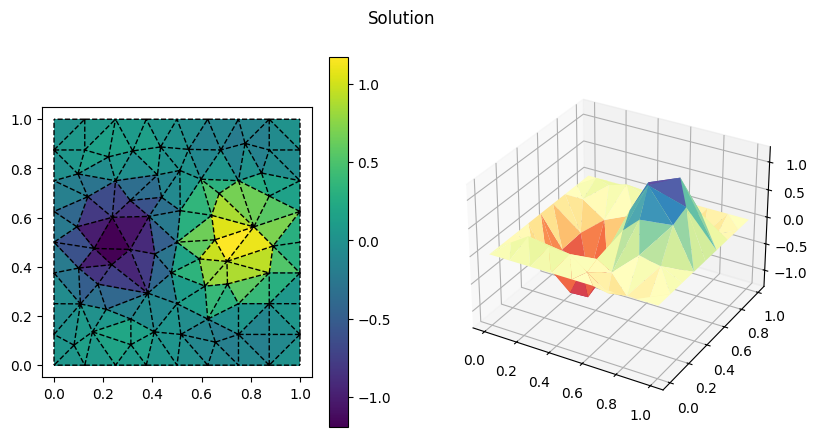

In [37]:
# --- Parametro online da testare ---
mu_online = np.array([0.7, 0.9])  # esempio, puoi cambiarlo

# --- Definisci la nuova forzante parametrica per mu_online ---
def SourceTerm_online(numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    values_f = 100.0 * np.sin(2 * np.pi * matPoints[0, :]) * np.cos(2 * np.pi * matPoints[1, :])
    return values_f.ctypes.data

# --- Assembla termine di forzante per il nuovo mu ---
forcing_full = gedim.AssembleForcingTerm(SourceTerm_online, problemData, lib)  # dimensione: DOF

# --- Proiezione sullo spazio ridotto ---
forcing_reduced = basis_functions.T @ forcing_full  # dimensione: N

# --- Risolvi il sistema ridotto ---
u_reduced = np.linalg.solve(reduced_stiff, forcing_reduced)

# --- Ricostruisci la soluzione nello spazio completo ---
u_full = basis_functions @ u_reduced # soluzione ridotta mappata nel full space

gedim.PlotSolution(mesh, dofs, strongs, u_full, np.zeros(problemData['NumberStrongs']))

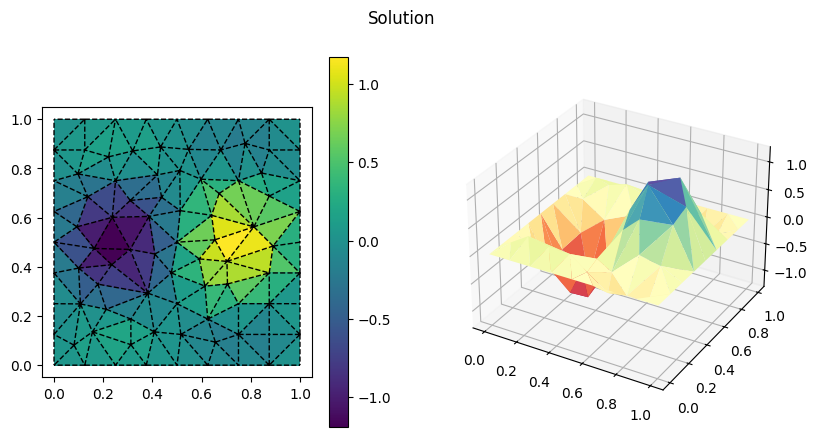

In [38]:
# Risolvo sistema full order (la soluzione "esatta" anche se non ho u analiticamente esplicita)
#[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Omega, problemData, lib)
#print("stiffness:", type(stiffness))
#try:
#    print("Shape stiffness:", stiffness.shape)
#except Exception as e:
#    print("Errore shape stiffness:", e)
# stiffness è sparsa e np.linalg.solve non supporta matrici sparse

from scipy.sparse.linalg import spsolve

u_fom = spsolve(stiffness, forcing_full)
gedim.PlotSolution(mesh, dofs, strongs, u_fom, np.zeros(problemData['NumberStrongs']))

In [39]:
### computing error


error_function = u_fom - u_full
error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
absolute_error = np.sqrt(abs(error_norm_squared_component))
#rel_err = []
#abs_err = []
#rel_err.append(relative_error
#abs_err.append(absolute_error)

full_solution_norm_squared_component = np.transpose(u_fom) @  inner_product @ u_fom
relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
#rel_err.append(relative_error)


2. SOLVE THE PROBLEM WITH A PARAMETRIC PINN